In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from allison.nn import Relu,Linear
from allison.nn import SGDMomentum
from allison.nn import Tensor,no_grad
from allison.nn import NeuralNetwork
from allison.nn import  MSELoss
from allison.datasets import train_test_split
from allison.nn import r2_score
import pandas as pd

# Datos

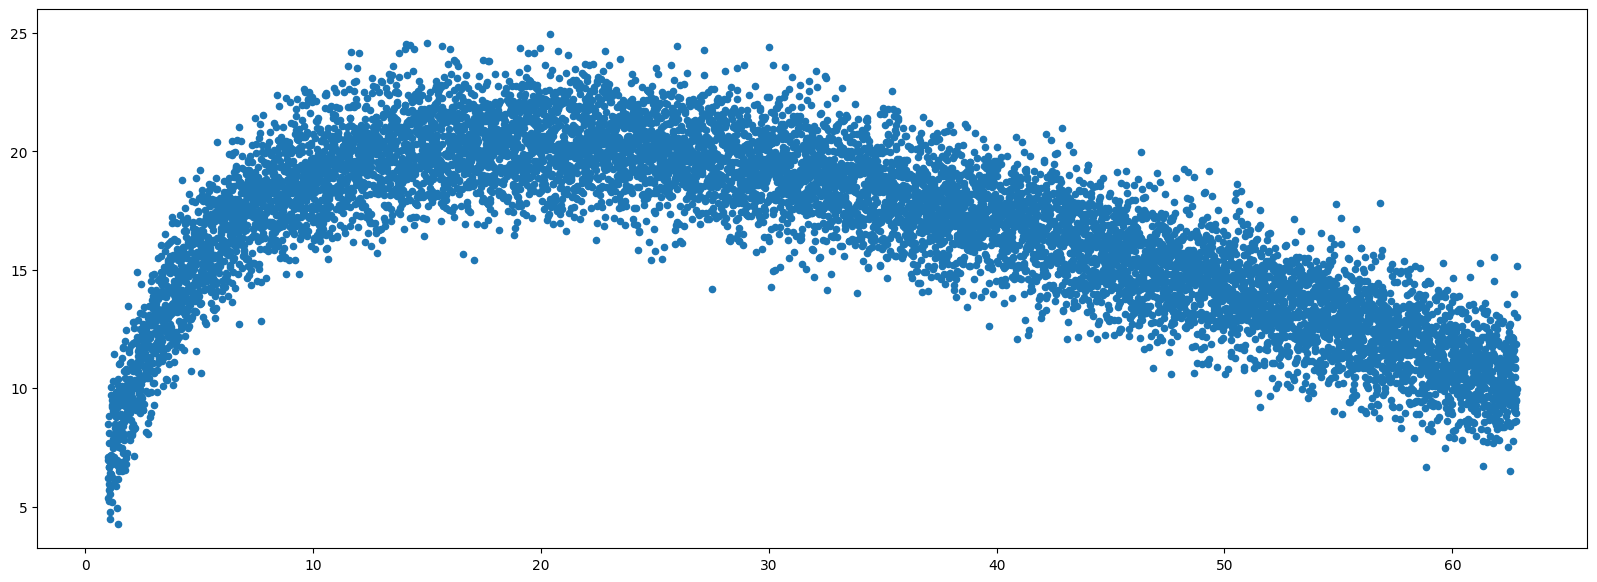

In [2]:
# Datos
points = 10000
x1 = np.linspace(1, 20*np.pi, points)
x2 = np.linspace(1, 20*np.pi, points)

# Definimos la salida
y = 10*np.log(x1+1) + -0.5*x2 + 1.5*np.random.randn(points)


data = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})
data.head()

plt.figure(figsize=(20,7))
plt.scatter(data['x2'], data['y'], s=20)
plt.show()


# Preprocessing

x1    31.848049
x2    31.848049
y     16.702880
dtype: float64
x1    17.857737
x2    17.857737
y      3.596498
dtype: float64


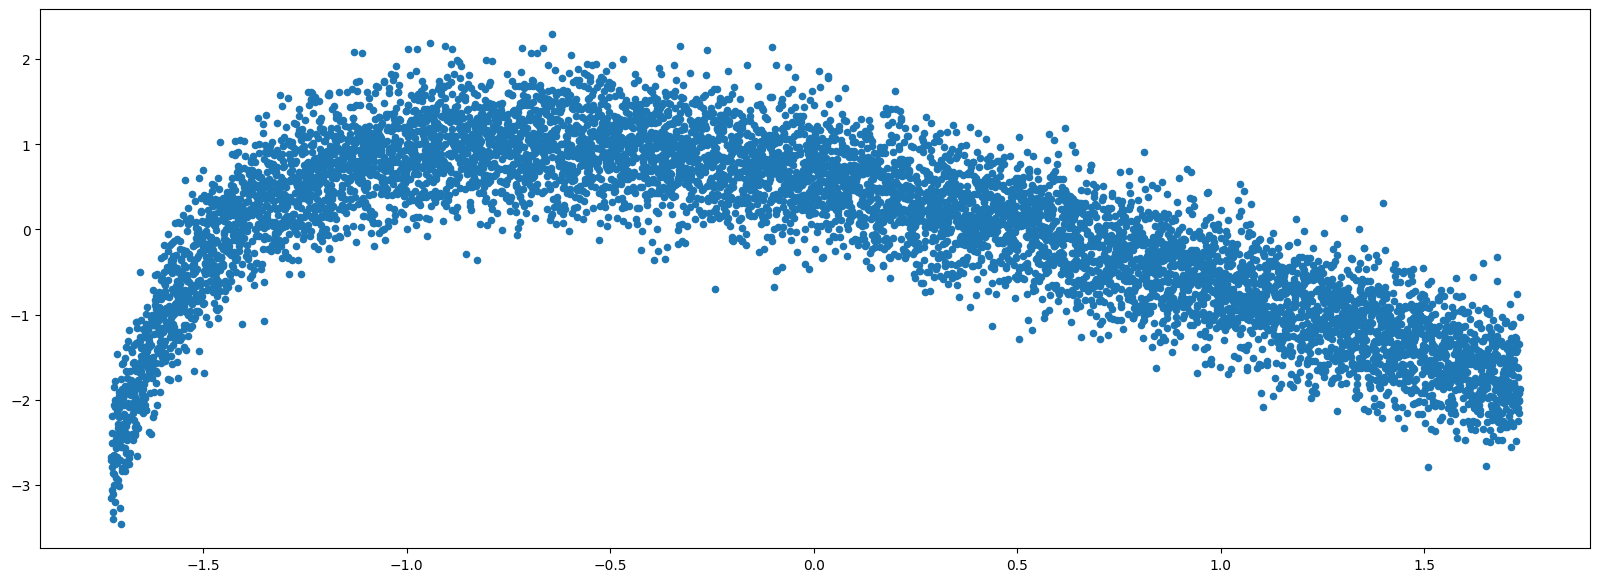

In [3]:
# Train test split and normalization

df_train, df_test = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)


def_train_mean = df_train.mean()
def_train_std = df_train.std()

print(def_train_mean)
print(def_train_std)

df_train = (df_train-def_train_mean)/def_train_std
df_test = (df_test-def_train_mean)/def_train_std

plt.figure(figsize=(20,7))
plt.scatter(df_train['x2'], df_train['y'], s=20)
plt.show()


In [4]:
X_train = Tensor(df_train[['x1', 'x2']].values)
Y_train = Tensor(df_train[['y']].values)

X_test = Tensor(df_test[['x1', 'x2']].values)
Y_test = Tensor(df_test[['y']].values)


print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (8000, 2)
Y_train shape: (8000, 1)
X_test shape: (2000, 2)
Y_test shape: (2000, 1)


In [5]:
class Network(NeuralNetwork):
    def __init__(self):
        super().__init__()
        self.fc1 = Linear(2, 64)
        self.relu = Relu()
        self.fc2 = Linear(64, 32)
        self.fc3 = Linear(32, 1)

    def forward(self, x: Tensor) -> Tensor:
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x


net = Network()



criterion = MSELoss()
optimizer = SGDMomentum(net.parameters(), learning_rate=1e-3, momentum=0.9)


In [6]:

# %%
# Bucle de entrenamiento mejorado
for epoch in range(5000 + 1):
    Y_pred = net(X_train)
    loss = criterion(Y_train,Y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        r2_train = r2_score(Y_train, Y_pred)
        with no_grad():
            Y_pred = net(X_test)
            r2_test = r2_score(Y_test, Y_pred)
        print(f"Epoch {epoch:5d} | Loss: {loss.data:.4f} | R2_Train: {100*r2_train:5.2f} % | R2_Test: {100*r2_test:5.2f} %")
        if r2_test > 0.95:  # Mejoramos el criterio de parada
            print(f"Entrenamiento completado en {epoch} epochs!")
            break

Epoch     0 | Loss: 3.0152 | R2_Train: -201.56 % | R2_Test: -152.63 %
Epoch   100 | Loss: 0.4394 | R2_Train: 56.05 % | R2_Test: 56.21 %
Epoch   200 | Loss: 0.3696 | R2_Train: 63.03 % | R2_Test: 63.39 %
Epoch   300 | Loss: 0.3500 | R2_Train: 65.00 % | R2_Test: 65.51 %
Epoch   400 | Loss: 0.3388 | R2_Train: 66.12 % | R2_Test: 66.72 %
Epoch   500 | Loss: 0.3270 | R2_Train: 67.29 % | R2_Test: 67.94 %
Epoch   600 | Loss: 0.3152 | R2_Train: 68.48 % | R2_Test: 69.12 %


KeyboardInterrupt: 

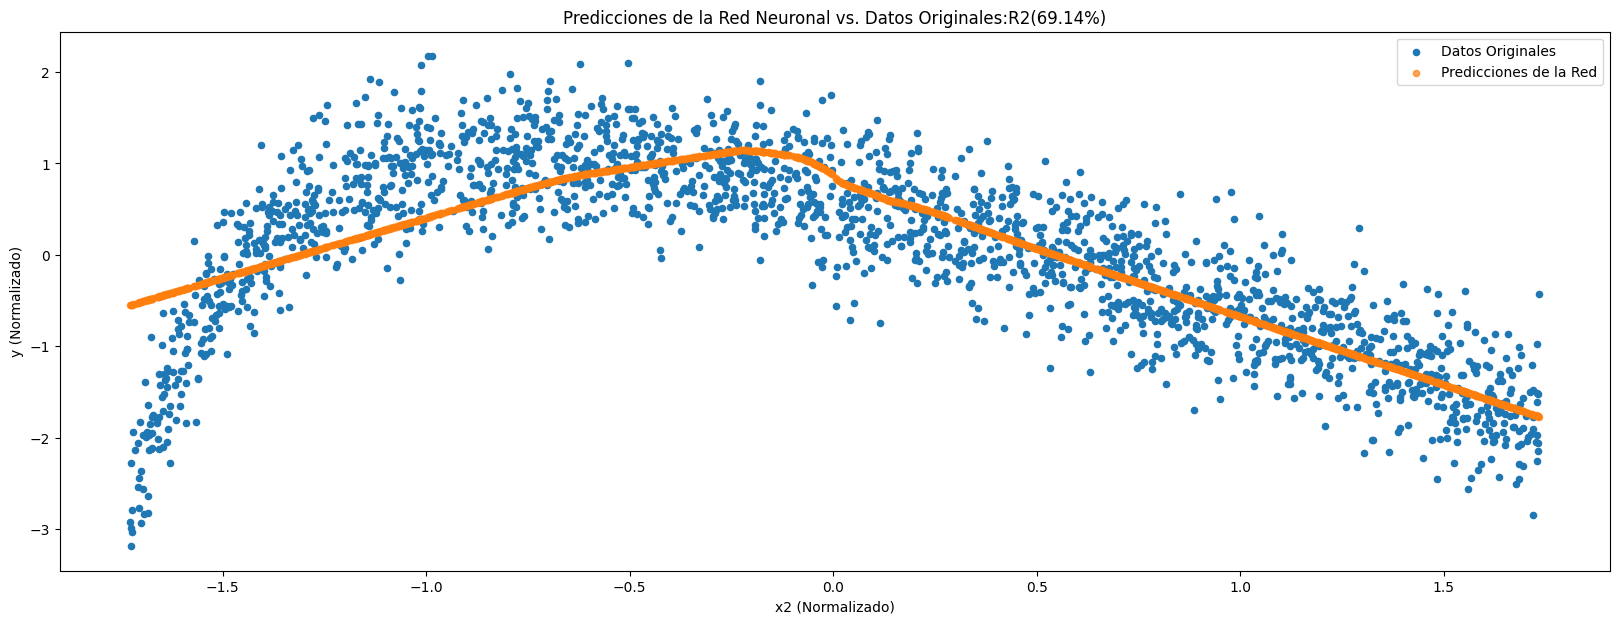

In [7]:
# %%
# Visualización final

with no_grad():
    y_pred = net(X_test)

r2 = r2_score(Y_test, y_pred)
plt.figure(figsize=(20, 7))
plt.scatter(X_test.data[:, 1], Y_test.data, label='Datos Originales', s=20)
plt.scatter(X_test.data[:, 1], y_pred.data, label='Predicciones de la Red', s=20, alpha=0.7)
plt.title(f'Predicciones de la Red Neuronal vs. Datos Originales:R2({100*r2:.2f}%)')
plt.xlabel('x2 (Normalizado)')
plt.ylabel('y (Normalizado)')
plt.legend()
plt.show()


# Rescaling

In [8]:
print(y_pred.data)

[[-0.36747036]
 [-0.35197917]
 [ 0.07968562]
 ...
 [ 0.59319319]
 [-0.15788884]
 [-0.36378451]]


In [9]:
y_final = y_pred.data * def_train_std['y'] + def_train_mean['y']
y_final_rescaled = y_final.flatten()
print(y_final_rescaled)

[15.3812735  15.43698756 16.98946915 ... 18.83629813 16.13503306
 15.39452968]
